In [1]:
import torch
from pathlib import Path
import os
from sklearn.metrics import r2_score
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
from Model_simple import *
from Unet_model import *
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
import scipy.stats as st
plt.style.use('default')

In [22]:
# pressure: min=24000000.0 | max=37970486.543
# saturation: min=0.0 | max=0.87943658597

# scatter

In [2]:
device = torch.device('cuda')
test_model_24 = InceptionLSTM(3, 1, 128, 24, 0.3).float().to(device)
test_model_24.load_state_dict(torch.load(f'model_weights_10.25-22.21_p@85.pth', map_location=device))    # [notice] match !!
test_model_24.eval()
print('done')

unet = UNET(in_channels=4, out_channels=1).float().to(device)
unet.load_state_dict(torch.load('Unet_model_weights_10.12_p.pth', map_location=device))
unet.eval()
print('done')

done
done


In [3]:
def get_one_case_pre_r2_scatter(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'tttt_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = test_model_24(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    case_pred_list = []
    case_true_list = []
    for ii in range(24):
        y_tmp = list(y_arr[ii, :, :].flatten())
        true_tmp = list(true[ii, :, :].flatten())
        case_pred_list += y_tmp
        case_true_list += true_tmp
    return case_pred_list, case_true_list


def u_get_one_case_pre_r2_scatter(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(24):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list += list(y_arr.flatten())

    true_list = []
    for tt in range(24):
        true = torch.load(f'ttt_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list += list(true.flatten())
        
    return y_list, true_list

In [6]:
total_pred, total_true = [], []
u_total_pred, u_total_true = [], []
for case_num in np.arange(5000, 5250):
    tmp_pred, tmp_true = get_one_case_pre_r2_scatter(case_num)
    u_tmp_pred, u_tmp_true = u_get_one_case_pre_r2_scatter(case_num)
    
    total_pred += tmp_pred
    total_true += tmp_true
    u_total_pred += u_tmp_pred
    u_total_true += u_tmp_true

In [7]:
max_value = np.max([np.max(total_true), np.max(total_pred), np.max(u_total_pred)])
print(max_value)

34.403774


In [8]:
plt.figure(figsize=(5,5), dpi=1000)
plt.xlim(24, max_value)
plt.ylim(24, max_value)

u_r2 = r2_score(u_total_true, u_total_pred)
lstm_r2 = r2_score(total_true, total_pred)
print(u_r2, lstm_r2)

plt.scatter(u_total_pred, u_total_true, c='blue', s=3, label=f'U-Net: $R^2$={u_r2:.3f}', alpha=0.3, linewidths=0)
plt.scatter(total_pred, total_true, c='red', s=3, label=f'ED-ConvLSTM: $R^2$={lstm_r2:.3f}', alpha=0.3, linewidths=0)
plt.plot(np.linspace(24, max_value), np.linspace(24, max_value), ls='-.', lw=0.8, c='black')

plt.xlabel('Predicted Pressure (MPa)', fontsize=12)
plt.ylabel('Ground Truth Pressure (MPa)', fontsize=12)
lgnd = plt.legend(loc='upper left')
lgnd.legend_handles[0]._sizes = [20]
lgnd.legend_handles[1]._sizes = [20]
lgnd.legend_handles[0]._alpha = 1.0
lgnd.legend_handles[1]._alpha = 1.0
plt.savefig('chutu\\pre_scatter.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.close()

0.9723213079732179 0.9939239983001783


In [9]:
device = torch.device('cuda')
convlstm_s = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm_s.load_state_dict(torch.load(f'model_weights_10.30-15.28_s@84.pth', map_location=device))    # [notice] match !!
convlstm_s.eval()
print('done')

unet_s = UNET(in_channels=4, out_channels=1).float().to(device)
unet_s.load_state_dict(torch.load('Unet_model_weights_10.12_s.pth', map_location=device))
unet_s.eval()
print('done')

def lstm_s_scatter(case_num):
    min_v = 0.
    max_v = 0.87943658597

    with torch.no_grad():
        x = torch.load(f'tttt_train_s_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm_s(x.float().unsqueeze(0))
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v

    true = torch.load(f'tttt_train_s_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v

    case_pred_list = []
    case_true_list = []
    for ii in range(24):
        y_tmp = list(y_arr[ii, :, :].flatten())
        true_tmp = list(true[ii, :, :].flatten())
        case_pred_list += y_tmp
        case_true_list += true_tmp
    return case_pred_list, case_true_list


def u_s_scatter(case_num):
    min_v = 0.
    max_v = 0.87943658597

    y_list = []
    for ts in range(24):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_s_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet_s(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            # y_arr = y_arr / 1e6
            y_list += list(y_arr.flatten())

    true_list = []
    for tt in range(24):
        true = torch.load(f'ttt_Unet_train_s_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        # true = true / 1e6
        true_list += list(true.flatten())

    return y_list, true_list

done
done


In [10]:
total_pred, total_true = [], []
u_total_pred, u_total_true = [], []
for case_num in np.arange(5000, 5250):
    tmp_pred, tmp_true = lstm_s_scatter(case_num)
    u_tmp_pred, u_tmp_true = u_s_scatter(case_num)

    total_pred += tmp_pred
    total_true += tmp_true
    u_total_pred += u_tmp_pred
    u_total_true += u_tmp_true
max_value = np.max([np.max(total_true), np.max(total_pred), np.max(u_total_pred)])
print(max_value)

0.7802769


In [11]:
plt.figure(figsize=(5,5), dpi=1000)
plt.xlim(0, max_value)
plt.ylim(0, max_value)

u_r2 = r2_score(u_total_true, u_total_pred)
lstm_r2 = r2_score(total_true, total_pred)
print(u_r2, lstm_r2)

plt.scatter(u_total_pred, u_total_true, c='blue', s=3, label=f'U-Net: $R^2$={u_r2:.3f}', alpha=0.3, linewidths=0)
plt.scatter(total_pred, total_true, c='red', s=3, label=f'ED-ConvLSTM: $R^2$={lstm_r2:.3f}', alpha=0.3, linewidths=0)
plt.plot(np.linspace(0, 1.0), np.linspace(0, 1.0), ls='-.', lw=0.8, c='black')

plt.xlabel('Predicted Saturation', fontsize=12)
plt.ylabel('Ground Truth Saturation', fontsize=12)
lgnd = plt.legend(loc='upper left')
lgnd.legend_handles[0]._sizes = [20]
lgnd.legend_handles[1]._sizes = [20]
lgnd.legend_handles[0]._alpha = 1.0
lgnd.legend_handles[1]._alpha = 1.0
plt.savefig('chutu\\sat_scatter.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.close()

0.9482816918671109 0.9906118088400673


# RMSE through time: extrapolate

In [7]:
device = torch.device('cuda')
convlstm = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm.load_state_dict(torch.load(f'model_weights_10.25-22.21_p@85.pth', map_location=device))    # [notice] match !!
convlstm.eval()
print('done')

unet = UNET(in_channels=4, out_channels=1).float().to(device)
unet.load_state_dict(torch.load('Unet_model_weights_10.12_p.pth', map_location=device))
unet.eval()
print('done')

def rmse_lstm(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'tttt_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'ttt_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        rmse_list.append(rmse_v)
    return rmse_list

rmse_lstm_whole = []
rmse_u_whole = []
for cc in np.arange(5000, 5250):
    lstm_ = rmse_lstm(cc)
    u_ = rmse_u(cc)
    rmse_lstm_whole.append(lstm_)
    rmse_u_whole.append(u_)
rmse_lstm_whole = np.stack(rmse_lstm_whole, axis=0)
rmse_u_whole = np.stack(rmse_u_whole, axis=0)
print(rmse_lstm_whole.shape, rmse_u_whole.shape)

lstm_mean_list = []
lstm_up_list = []
lstm_low_list = []

u_mean_list = []
u_up_list = []
u_low_list = []

for ttt in range(60):
    lstm_tmp = rmse_lstm_whole[:, ttt]
    u_tmp = rmse_u_whole[:, ttt]

    lstm_low, lstm_up = st.norm.interval(0.95, loc=np.mean(lstm_tmp), scale=st.sem(lstm_tmp))
    lstm_mean = np.mean(lstm_tmp)

    u_low, u_up = st.norm.interval(0.95, loc=np.mean(u_tmp), scale=st.sem(u_tmp))
    u_mean = np.mean(u_tmp)

    lstm_mean_list.append(lstm_mean)
    lstm_up_list.append(lstm_up)
    lstm_low_list.append(lstm_low)

    u_mean_list.append(u_mean)
    u_up_list.append(u_up)
    u_low_list.append(u_low)

done
done
(250, 60) (250, 60)


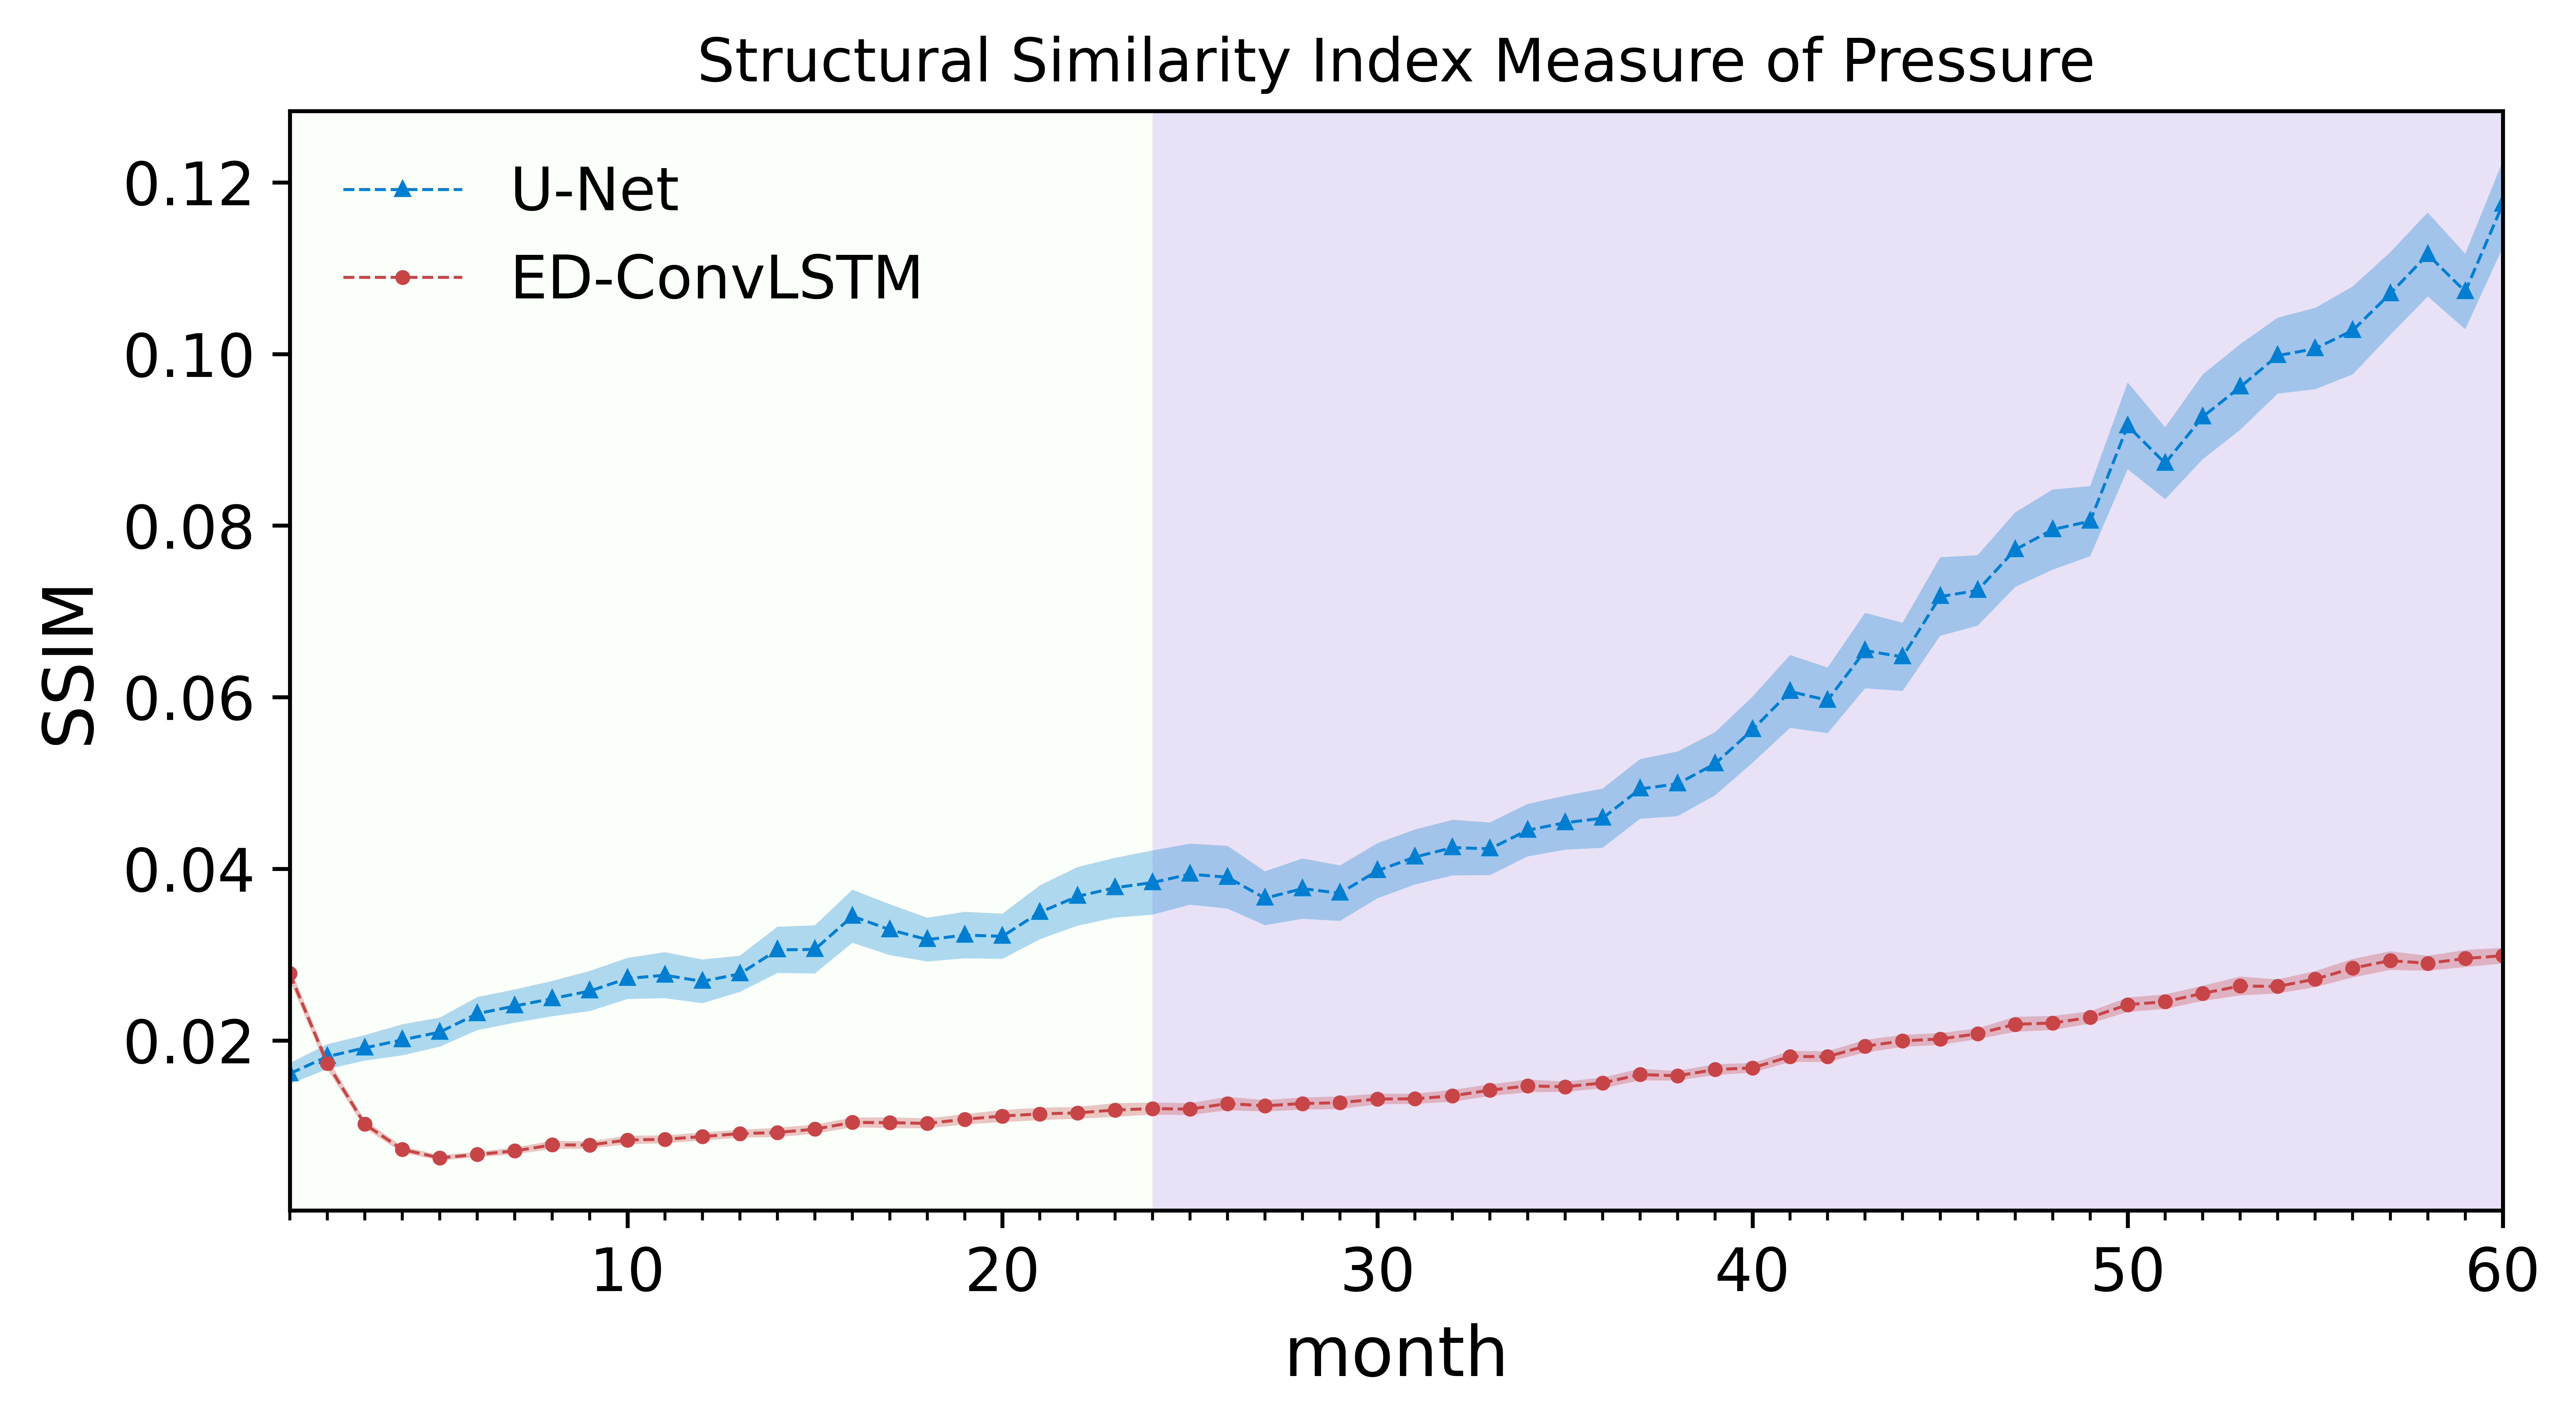

In [8]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 4), dpi=1000)
ax = plt.gca()
ax.axvspan(0, 24, facecolor='honeydew', alpha=0.3)
ax.axvspan(24, 60, facecolor='mediumpurple', alpha=0.2)


xx = np.arange(1, 61)
plt.xlim(1, 60)
# plt.ylim(0.5, 1)
plt.plot(xx, u_mean_list, c='#007FD2', label='U-Net', marker='^', markersize=2, linewidth=0.6, ls='--',)
plt.fill_between(xx, u_low_list, u_up_list, alpha=0.3, color='#007FD2', edgecolor=None)
plt.plot(xx, lstm_mean_list, c='#C74546', label='ED-ConvLSTM', marker='o', markersize=2, linewidth=0.6, ls='--')
plt.fill_between(xx, lstm_low_list, lstm_up_list, alpha=0.3, color='#C74546', edgecolor=None)


# plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
# ax.yaxis.set_major_locator(plt.MultipleLocator(5))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(2.5))
# plt.ylim(0.01, 0.08)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Normalized Root Mean Square Error of Pressure', fontsize=12)
plt.title('Structural Similarity Index Measure of Pressure', fontsize=12)
plt.xlabel('month', fontsize=14)
plt.ylabel('SSIM', fontsize=14)
plt.legend(frameon=False, fontsize=12)
# plt.grid(ls=':', lw=0.5, alpha=0.5, which='both', axis='both')

# plt.savefig('chutu\\ssim_extra_pre.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.close()

In [4]:
device = torch.device('cuda')
convlstm_s = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm_s.load_state_dict(torch.load(f'model_weights_10.30-15.28_s@84.pth', map_location=device))    # [notice] match !!
convlstm_s.eval()
print('done')

unet_s = UNET(in_channels=4, out_channels=1).float().to(device)
unet_s.load_state_dict(torch.load('Unet_model_weights_10.12_s_test3.pth', map_location=device))
unet_s.eval()
print('done')

def rmse_lstm_s(case_num):
    min_v = 0.
    max_v = 0.87943658597

    with torch.no_grad():
        x = torch.load(f'tttt_train_s_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm_s(x.float().unsqueeze(0))
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v

    true = torch.load(f'tttt_train_s_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u_s(case_num):
    min_v = 0.
    max_v = 0.87943658597

    rmse_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_s_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet_s(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v

            true = torch.load(f'ttt_Unet_train_s_y\\{case_num:>04}_{ts}.pt').squeeze().numpy()    # [64, 64]
            true = true * (max_v - min_v) + min_v

            rmse_v = ssim(true, y_arr,data_range=1.0)

            rmse_list.append(rmse_v)
    return rmse_list

rmse_lstm_whole_s = []
rmse_u_whole_s = []
for cc in np.arange(5000, 5250):
    lstm_s = rmse_lstm_s(cc)
    u_s = rmse_u_s(cc)
    rmse_lstm_whole_s.append(lstm_s)
    rmse_u_whole_s.append(u_s)
rmse_lstm_whole_s = np.stack(rmse_lstm_whole_s, axis=0)
rmse_u_whole_s = np.stack(rmse_u_whole_s, axis=0)
print(rmse_lstm_whole_s.shape, rmse_u_whole_s.shape)

lstm_mean_list_s = []
lstm_up_list_s = []
lstm_low_list_s = []

u_mean_list_s = []
u_up_list_s = []
u_low_list_s = []

for ttt in range(60):
    lstm_tmp_s = rmse_lstm_whole_s[:, ttt]
    u_tmp_s = rmse_u_whole_s[:, ttt]

    lstm_low_s, lstm_up_s = st.norm.interval(0.95, loc=np.mean(lstm_tmp_s), scale=st.sem(lstm_tmp_s))
    lstm_mean_s = np.mean(lstm_tmp_s)

    u_low_s, u_up_s = st.norm.interval(0.95, loc=np.mean(u_tmp_s), scale=st.sem(u_tmp_s))
    u_mean_s = np.mean(u_tmp_s)

    lstm_mean_list_s.append(lstm_mean_s)
    lstm_up_list_s.append(lstm_up_s)
    lstm_low_list_s.append(lstm_low_s)

    u_mean_list_s.append(u_mean_s)
    u_up_list_s.append(u_up_s)
    u_low_list_s.append(u_low_s)

done
done
(250, 60) (250, 60)


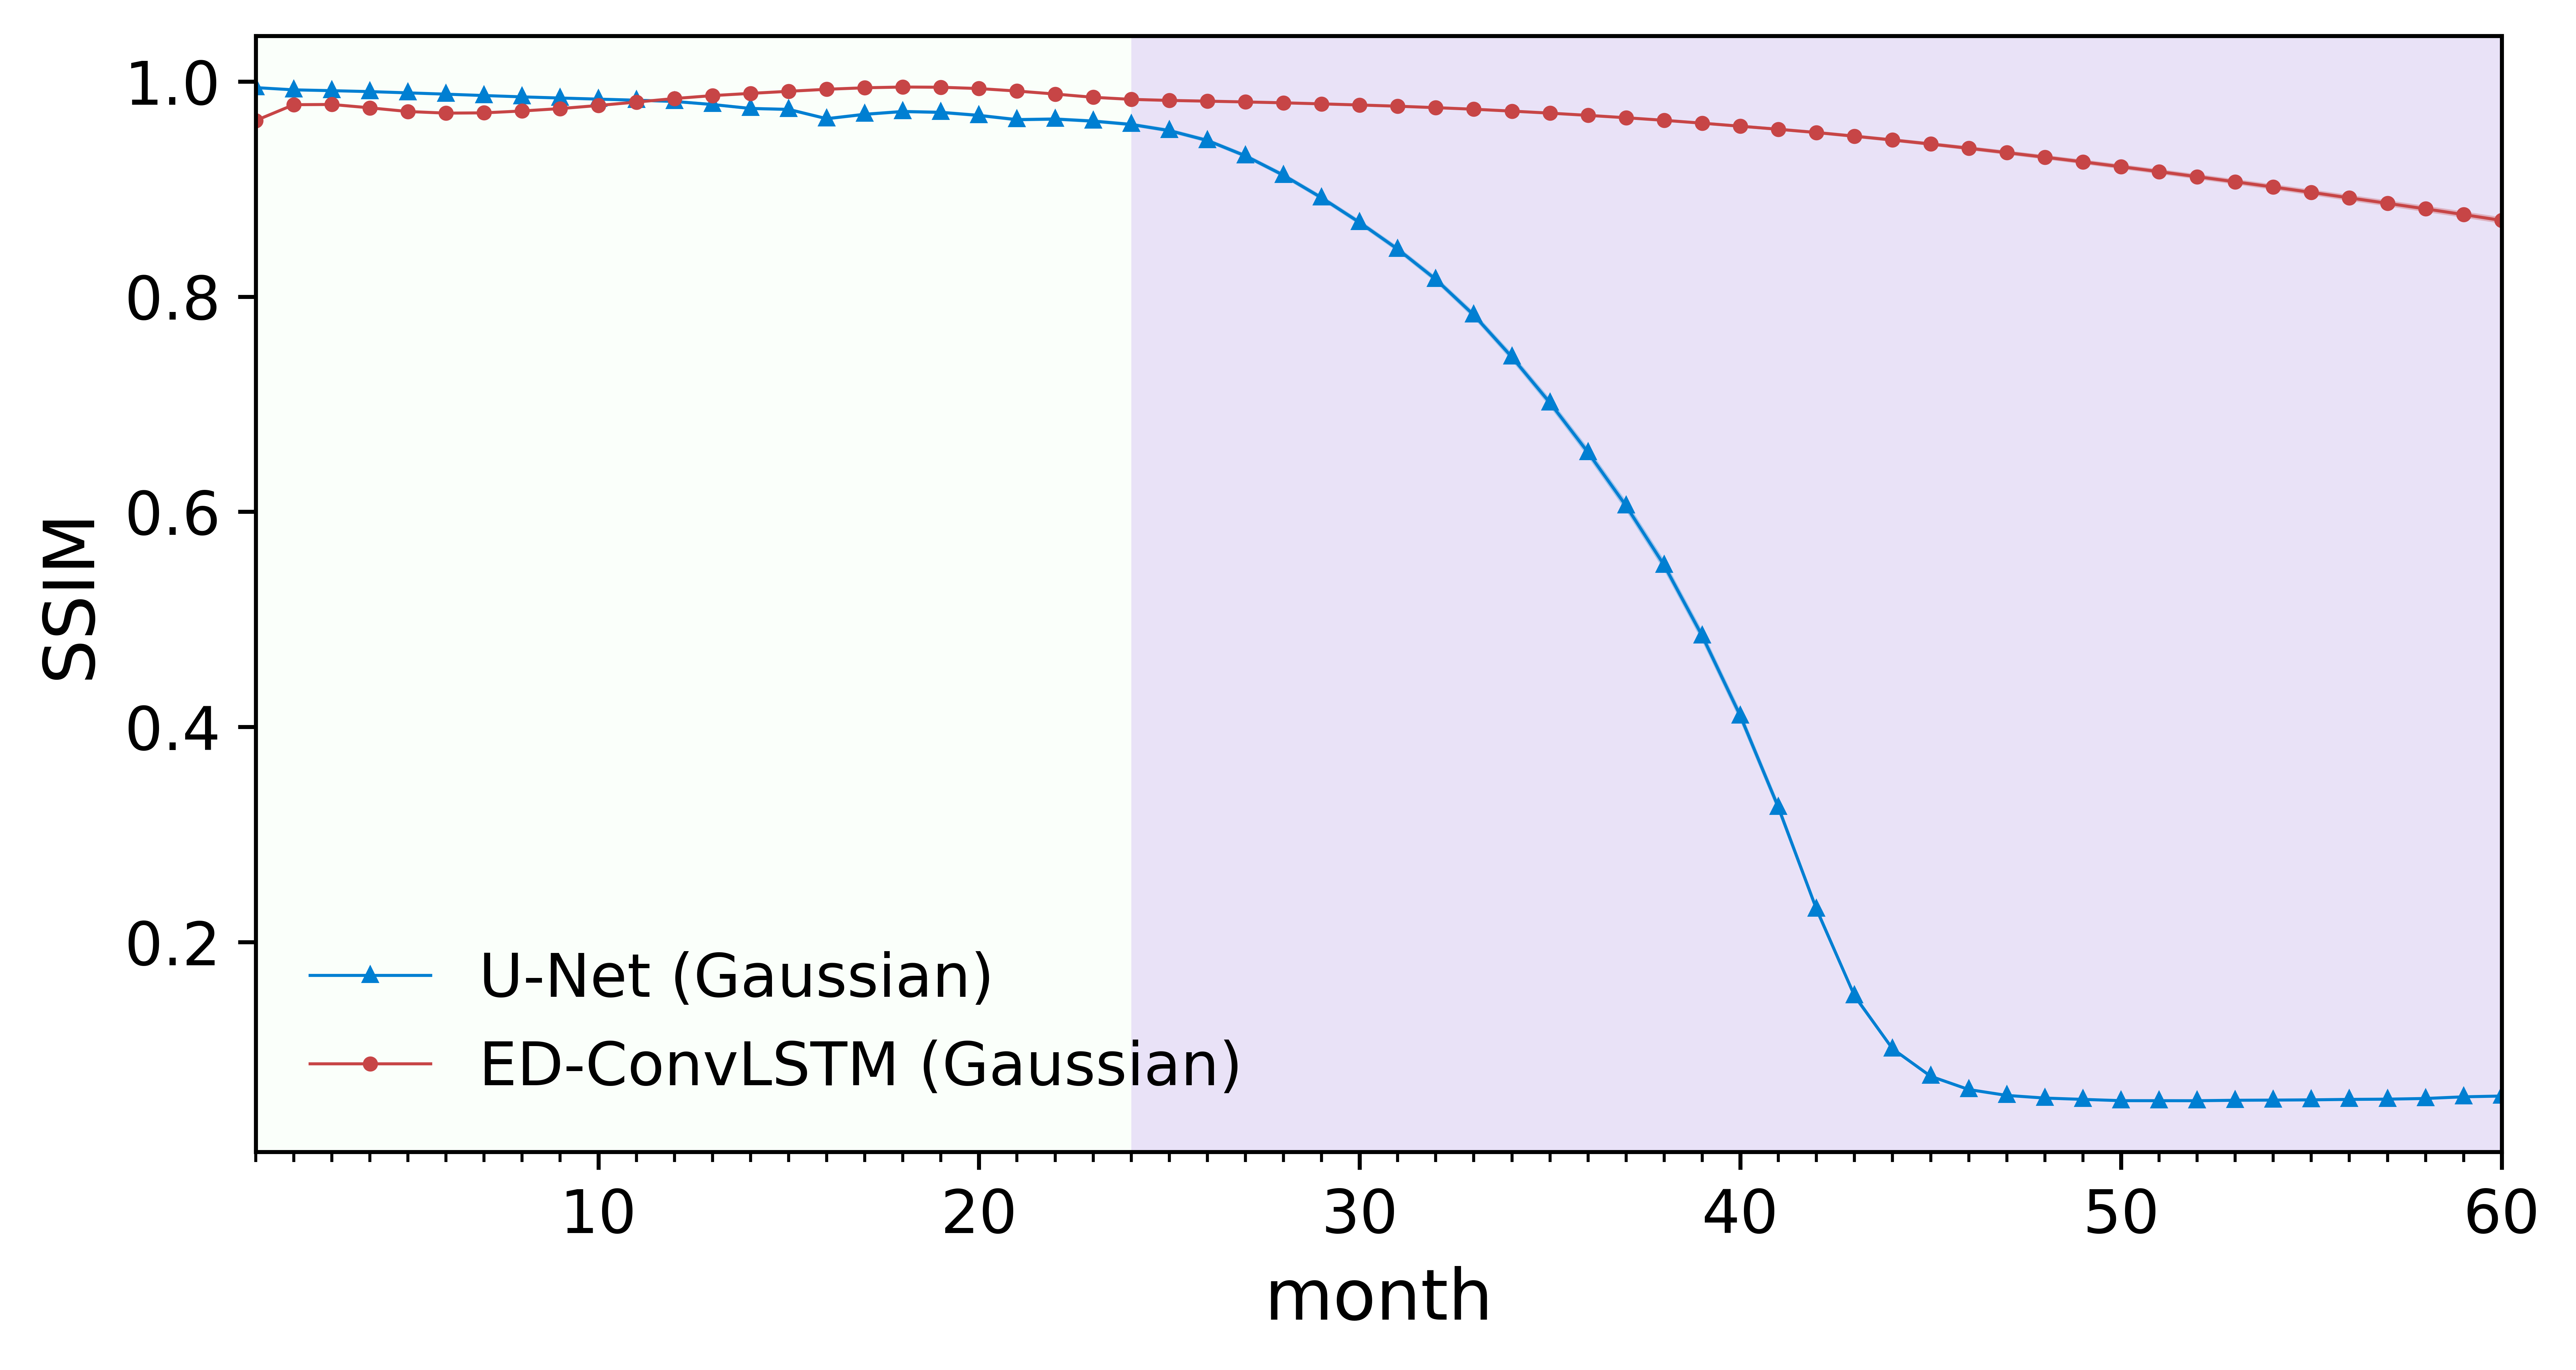

In [5]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 4), dpi=1000)
ax = plt.gca()
ax.axvspan(0, 24, facecolor='honeydew', alpha=0.3)
ax.axvspan(24, 60, facecolor='mediumpurple', alpha=0.2)


xx = np.arange(1, 61)
plt.xlim(1, 60)
# plt.ylim(0, 0.1)
plt.plot(xx, u_mean_list_s, c='#007FD2', label='U-Net (Gaussian)', marker='^', markersize=2, linewidth=0.6, ls='-')
plt.fill_between(xx, u_low_list_s, u_up_list_s, alpha=0.3, color='#007FD2', edgecolor=None)
plt.plot(xx, lstm_mean_list_s, c='#C74546', label='ED-ConvLSTM (Gaussian)', marker='o', markersize=2, linewidth=0.6, ls='-')
plt.fill_between(xx, lstm_low_list_s, lstm_up_list_s, alpha=0.3, color='#C74546', edgecolor=None)


# plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.002))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
# plt.ylim(top=0.16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Normalized Root Mean Square Error of Saturation', fontsize=12)
# plt.title('Structural Similarity Index Measure of Saturation', fontsize=12)
plt.xlabel('month', fontsize=14)
plt.ylabel('SSIM', fontsize=14)
plt.legend(frameon=False, fontsize=12, loc='lower left')
# plt.grid(ls=':', lw=0.5, alpha=0.5, which='both', axis='both')

# plt.savefig('chutu\\Structural Similarity Index Measure of Saturation.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.close()

# HIST of R2 FOR EXTRA

In [27]:
device = torch.device('cuda')
convlstm = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm.load_state_dict(torch.load(f'model_weights_10.25-22.21_p@85.pth', map_location=device))    # [notice] match !!
convlstm.eval()
print('done')

unet = UNET(in_channels=5, out_channels=1).float().to(device)
unet.load_state_dict(torch.load('Unet_model_weights_10.12_p.pth', map_location=device))
unet.eval()
print('done')

def rmse_lstm(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'tttt_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'ttt_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


rmse_lstm_whole = []
rmse_u_whole = []
for cc in np.arange(5000, 5250):
    lstm_ = rmse_lstm(cc)
    u_ = rmse_u(cc)
    rmse_lstm_whole.append(lstm_)
    rmse_u_whole.append(u_)
rmse_lstm_whole = np.stack(rmse_lstm_whole, axis=0)
rmse_u_whole = np.stack(rmse_u_whole, axis=0)
print(rmse_lstm_whole.shape, rmse_u_whole.shape)

# ==================================================================================SAT=============================================================================
device = torch.device('cuda')
convlstm = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm.load_state_dict(torch.load(f'model_weights_10.25-22.21_p@85.pth', map_location=device))    # [notice] match !!
convlstm.eval()
print('done')

unet = UNET(in_channels=5, out_channels=1).float().to(device)
unet.load_state_dict(torch.load('Unet_model_weights_10.12_p.pth', map_location=device))
unet.eval()
print('done')

def rmse_lstm(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'tttt_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'ttt_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


rmse_lstm_whole = []
rmse_u_whole = []
for cc in np.arange(5000, 5250):
    lstm_ = rmse_lstm(cc)
    u_ = rmse_u(cc)
    rmse_lstm_whole.append(lstm_)
    rmse_u_whole.append(u_)
rmse_lstm_whole = np.stack(rmse_lstm_whole, axis=0)
rmse_u_whole = np.stack(rmse_u_whole, axis=0)
print(rmse_lstm_whole.shape, rmse_u_whole.shape)



done
done
(250, 60) (250, 60)


In [28]:
lstm_sample_r2 = np.mean(rmse_lstm_whole, axis=1)
u_sample_r2 = np.mean(rmse_u_whole, axis=1)
print(lstm_sample_r2.shape, u_sample_r2.shape)

(250,) (250,)


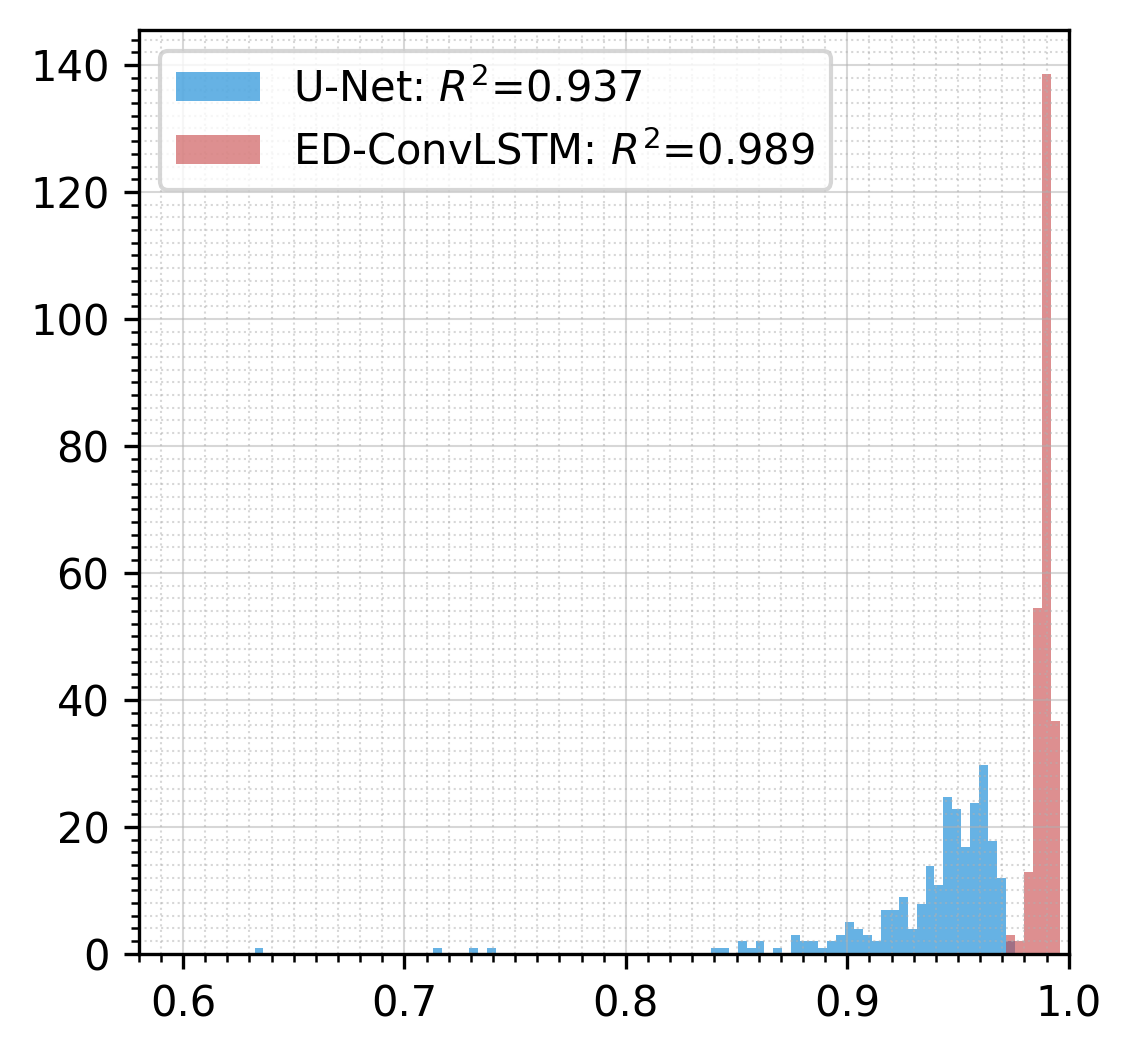

In [111]:
plt.figure(figsize=(4,4), dpi=300)
ax=plt.gca()
plt.hist(u_sample_r2, bins=np.linspace(0.6, 1, 100), density=True, color='#007FD2', alpha=0.6, label=f'U-Net: $R^2$={np.mean(u_sample_r2):.3f}')
plt.hist(lstm_sample_r2, bins=np.linspace(0.6, 1, 100), density=True, color='#C74546', alpha=0.6, label=f'ED-ConvLSTM: $R^2$={np.mean(lstm_sample_r2):.3f}')
plt.legend(loc='upper left')
plt.grid(ls='-', lw=0.5, alpha=0.5, which='major', axis='both')
plt.grid(ls=':', lw=0.5, alpha=0.5, which='minor', axis='both')
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))
plt.xlim(right=1)
plt.show()

(250, 2)


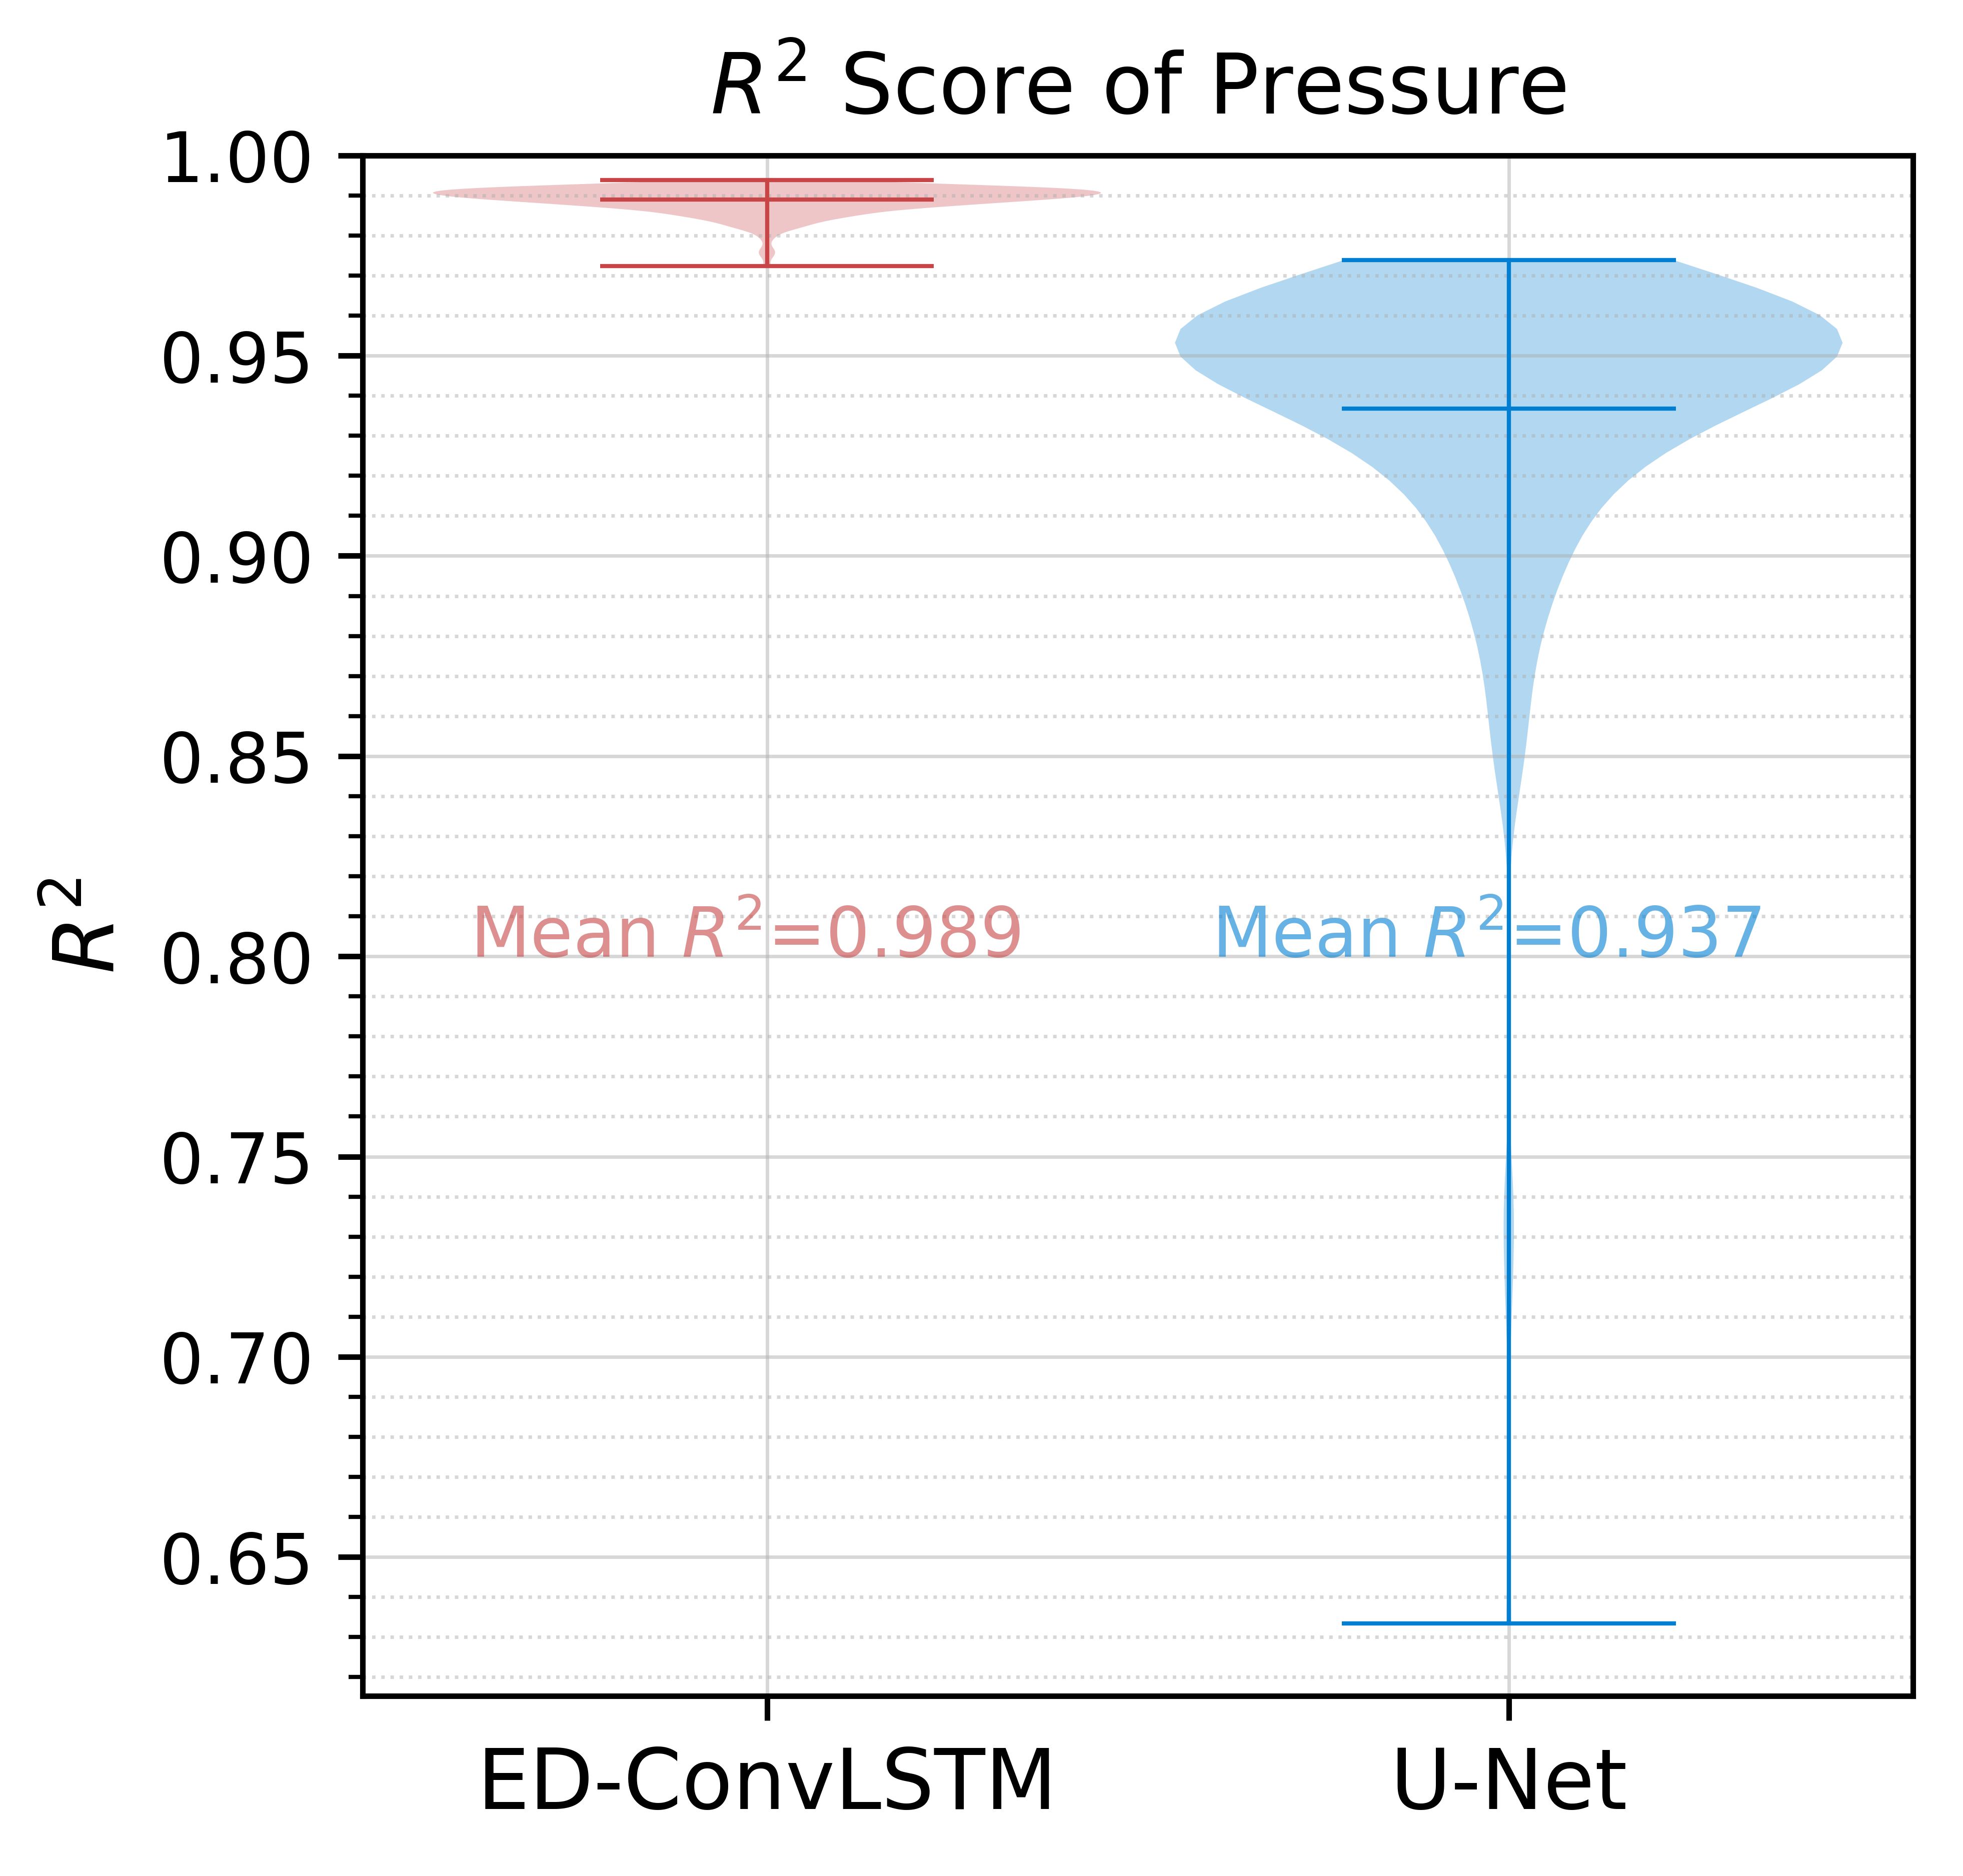

In [29]:
violin_data = np.stack((lstm_sample_r2, u_sample_r2), axis=1)
print(violin_data.shape)

plt.figure(figsize=(8,4), dpi=100)
ax=plt.gca()

colors = ['#C74546', '#007FD2']

plots = plt.violinplot(violin_data, vert=True, showmeans=True, widths=0.9)
# u_violin = plt.violinplot(u_sample_r2, positions=2)
for pc, color in zip(plots['bodies'], colors):
    pc.set_facecolor(color)
plots['cmeans'].set_colors(colors)
plots['cmaxes'].set_colors(colors)
plots['cmins'].set_colors(colors)
plots['cbars'].set_colors(colors)

plots['cbars'].set_linewidth(0.6)
plots['cmeans'].set_linewidth(0.6)
plots['cmins'].set_linewidth(0.6)
plots['cmaxes'].set_linewidth(0.6)

# plt.legend(loc='upper left')
plt.grid(ls='-', lw=0.5, alpha=0.5, which='major', axis='both')
plt.grid(ls=':', lw=0.5, alpha=0.5, which='minor', axis='both')
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.ylim(top=1)

ax.text(0.6, 0.8, F'Mean $R^2$={np.mean(lstm_sample_r2):.3f}', fontsize=10, c='#C74546', alpha=0.6)
ax.text(1.6, 0.8, F'Mean $R^2$={np.mean(u_sample_r2):.3f}', fontsize=10, c='#007FD2', alpha=0.6)
ax.set_xticks([1, 2,], labels=['ED-ConvLSTM', 'U-Net',], fontsize=12)
plt.ylabel('$R^2$', fontsize=12)
plt.title('$R^2$ Score of Pressure')
plt.savefig('chutu\\violin_pre_extra.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)